## **Week 5: Building our CNN**
### José Manuel López, Alex Martín, Marcos V. Conde

In [1]:
import tensorflow as tf
import warnings
import os
import gc
import matplotlib.pyplot as plt

from tensorflow.python.util import deprecation
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Dropout, BatchNormalization

In [2]:
DATA_DIR_SMALL = "./datasets/MIT_small_train_{}"
DATA_DIR_BIG = "./datasets/MIT_split"
IMG_SIZE = 64
BATCH_SIZE = 64
RANDOM_SEED = 42
CLASSES = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding']

In [3]:
# Disable Warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# VRAM broke without this
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.config.experimental_run_functions_eagerly(True)

try:
    # print model to see if it's compatible with Mixed Precision
    print(device_lib.list_local_devices()[3].physical_device_desc)
    # Change to TF16 mixed precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
except:
    pass

print(gpus[0])
print(tf.__version__)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.7.1


In [4]:
def get_dataset(path, aug):
    print("Loading: {}".format(path))
    if not aug:
        train_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)

        train_loader = train_datagen.flow_from_directory(
                path+'/train',  
                target_size=(IMG_SIZE, IMG_SIZE), 
                batch_size=BATCH_SIZE,
                classes = CLASSES,
                class_mode='categorical') 

        test_loader = test_datagen.flow_from_directory(
            path+'/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            classes = CLASSES,
            class_mode='categorical')
        
        return train_loader, test_loader
        
    else:

        train_datagen = ImageDataGenerator(rescale=1./255, featurewise_center = False, samplewise_center = False,
                                           featurewise_std_normalization = False, samplewise_std_normalization = False,
                                           rotation_range = 0.2, width_shift_range = 15, height_shift_range = 15, shear_range = 0.2,
                                           zoom_range = 0.2, fill_mode = "nearest", horizontal_flip = True
                                            )
        test_datagen = ImageDataGenerator(rescale=1./255)

        train_loader = train_datagen.flow_from_directory(
                path+'/train',  
                target_size=(IMG_SIZE, IMG_SIZE), 
                batch_size=BATCH_SIZE,
                classes = CLASSES,
                class_mode='categorical') 

        test_loader = test_datagen.flow_from_directory(
            path+'/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            classes = CLASSES,
            class_mode='categorical')
        
        return train_loader, test_loader



In [5]:
train_small, test_small = get_dataset(DATA_DIR_SMALL.format(1), aug = True)
train_big, test_big = get_dataset(DATA_DIR_BIG, aug = True)


examples = enumerate(train_big)
batch_idx, (example_data, example_targets) = next(examples)
print("Data Shape: {}".format(example_data.shape))

Loading: ./datasets/MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Loading: ./datasets/MIT_split
Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Data Shape: (64, 64, 64, 3)


In [36]:
def build_model(n_conv = 4, kernel_size = 5, conv = 256, n_dense = 2, dense = 1024, max_pool = False, dropout = False, batch_norm = False, opt = "adam"):
    #create model
    model = Sequential()
    #add model layers
    for idx, i in enumerate(range(n_conv)):
        if idx == 0:
            model.add(Conv2D(conv, kernel_size=kernel_size, activation="relu", input_shape=(IMG_SIZE,IMG_SIZE,3)))
            
            if max_pool:
                model.add(MaxPooling2D())
        else:
            model.add(Conv2D(conv, kernel_size=kernel_size, activation="relu"))
        
        if batch_norm:
            model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())

    for i in range(n_dense):
        model.add(Dense(dense, activation="relu"))
        if dropout:
            model.add(Dropout(0.2))
        
        if batch_norm:
            model.add(BatchNormalization())

    model.add(Dense(len(CLASSES), activation="softmax"))

    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=["accuracy"])

    return model



def plot_loss_accuracy(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))
    
    fig.suptitle(title, fontsize=16)

    # Plot history: CrossEntropy
    ax1.plot(history.history['loss'], label='CrossEntropy (training data)')
    ax1.plot(history.history['val_loss'], label='CrossEntropy (validation data)')
    ax1.set_title('Loss Function: Cross Entropy')
    ax1.set(xlabel='Epoch', ylabel='Loss Value')
    ax1.legend(loc="upper left")

    # Plot history: Accuracy
    ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
    ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    ax2.set_title('Accuracy')
    ax2.set(xlabel='Epoch', ylabel='Accuracy Value')
    ax2.legend(loc="upper left")

    plt.show()

## Checking Convolutional Layers

In [7]:
N_CONV  = 1
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 10s 277ms/step - loss: 2.0645 - accuracy: 0.1464 - val_loss: 2.0311 - val_accuracy: 0.1589
Epoch 2/50
29/29 [==============================] - 8s 276ms/step - loss: 1.9904 - accuracy: 0.2163 - val_loss: 1.9035 - val_accuracy: 0.2526
Epoch 3/50
29/29 [==============================] - 8s 280ms/step - loss: 1.9176 - accuracy: 0.2444 - val_loss: 1.8518 - val_accuracy: 0.3138
Epoch 4/50
29/29 [==============================] - 8s 277ms/step - loss: 1.8558 - accuracy: 0.2873 - val_loss: 1.7698 - val_accuracy: 0.3242
Epoch 5/50
29/29 [==============================] - 9s 320ms/step - loss: 1.8177 - accuracy: 0.2972 - val_loss: 1.7210 - val_accuracy: 0.3385
Epoch 6/50
29/29 [==============================] - 8s 266ms/step - loss: 1.7760 - accuracy: 0.3114 - val_loss: 1.6947 - val_accuracy: 0.3503
Epoch 7/50
29/29 [==============================] - 8s 262ms/step - loss: 1.7277 - accuracy: 0.3500 - val_loss: 1.6217 - val_accuracy: 0.3984
Epoch

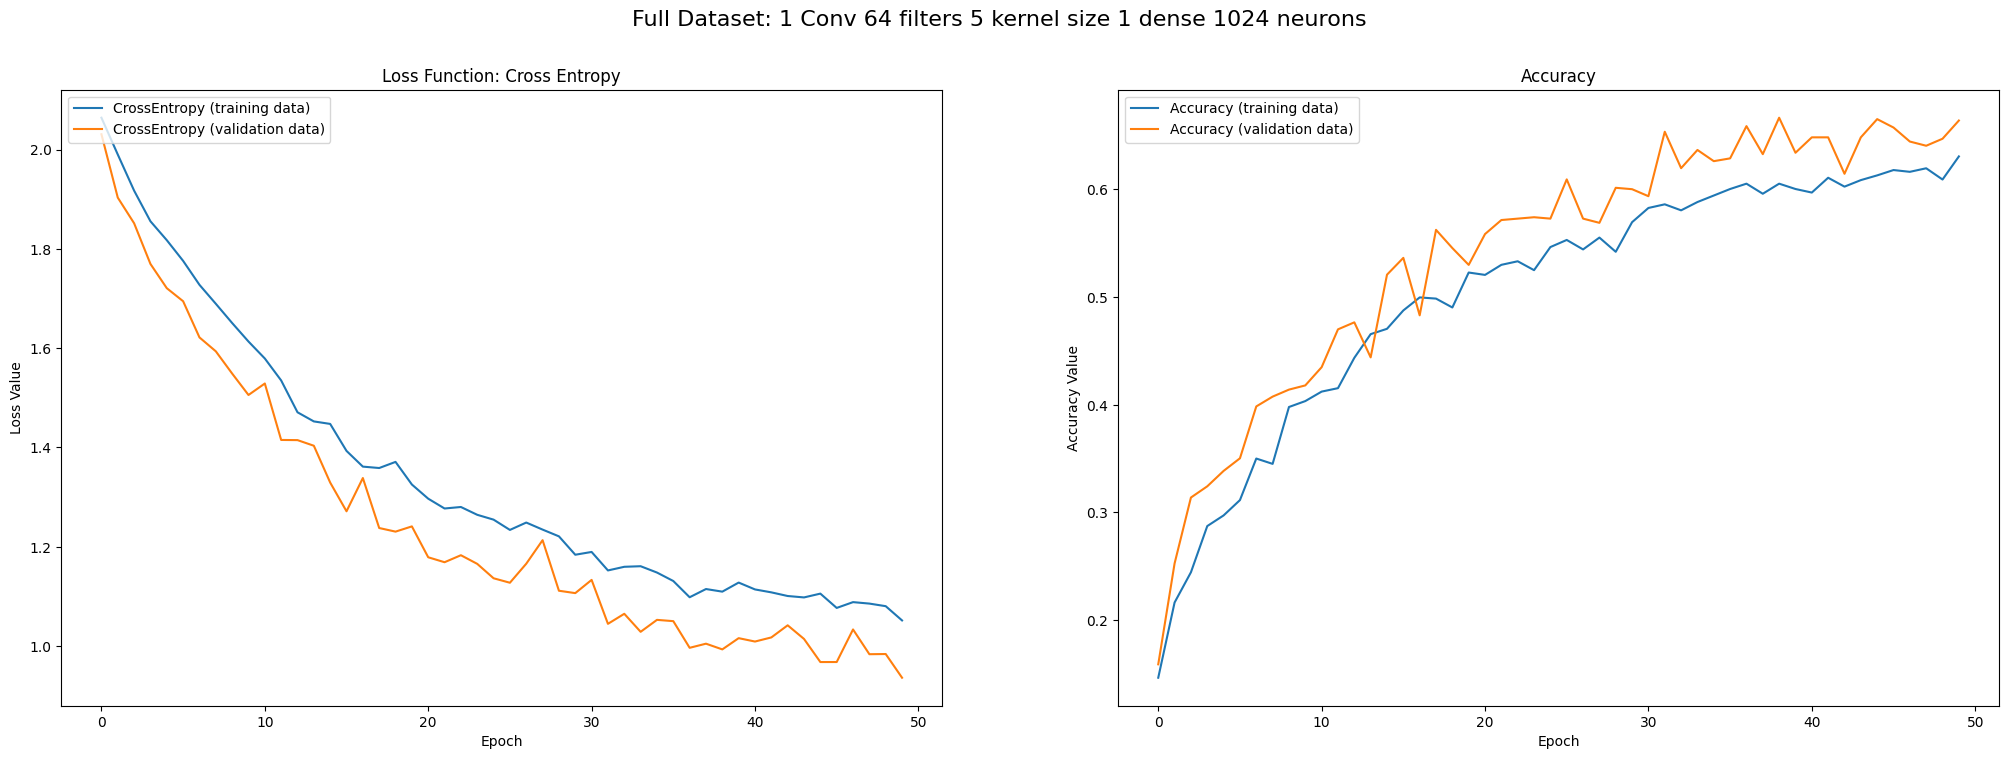

Train Accuracy: 0.6284  Train Loss: 1.0330
Test Accuracy: 0.6679  Test Loss: 0.9252


In [8]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))


In [9]:
N_CONV  = 2
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 8s 277ms/step - loss: 2.0431 - accuracy: 0.1767 - val_loss: 1.9030 - val_accuracy: 0.2565
Epoch 2/50
29/29 [==============================] - 9s 294ms/step - loss: 1.8790 - accuracy: 0.2911 - val_loss: 1.7074 - val_accuracy: 0.3424
Epoch 3/50
29/29 [==============================] - 9s 298ms/step - loss: 1.7450 - accuracy: 0.3302 - val_loss: 1.6003 - val_accuracy: 0.3841
Epoch 4/50
29/29 [==============================] - 9s 293ms/step - loss: 1.7025 - accuracy: 0.3434 - val_loss: 1.6637 - val_accuracy: 0.3490
Epoch 5/50
29/29 [==============================] - 8s 277ms/step - loss: 1.6059 - accuracy: 0.4018 - val_loss: 1.4755 - val_accuracy: 0.4232
Epoch 6/50
29/29 [==============================] - 8s 288ms/step - loss: 1.5121 - accuracy: 0.4386 - val_loss: 1.3945 - val_accuracy: 0.4753
Epoch 7/50
29/29 [==============================] - 9s 304ms/step - loss: 1.4456 - accuracy: 0.4562 - val_loss: 1.2912 - val_accuracy: 0.5182
Epoch 

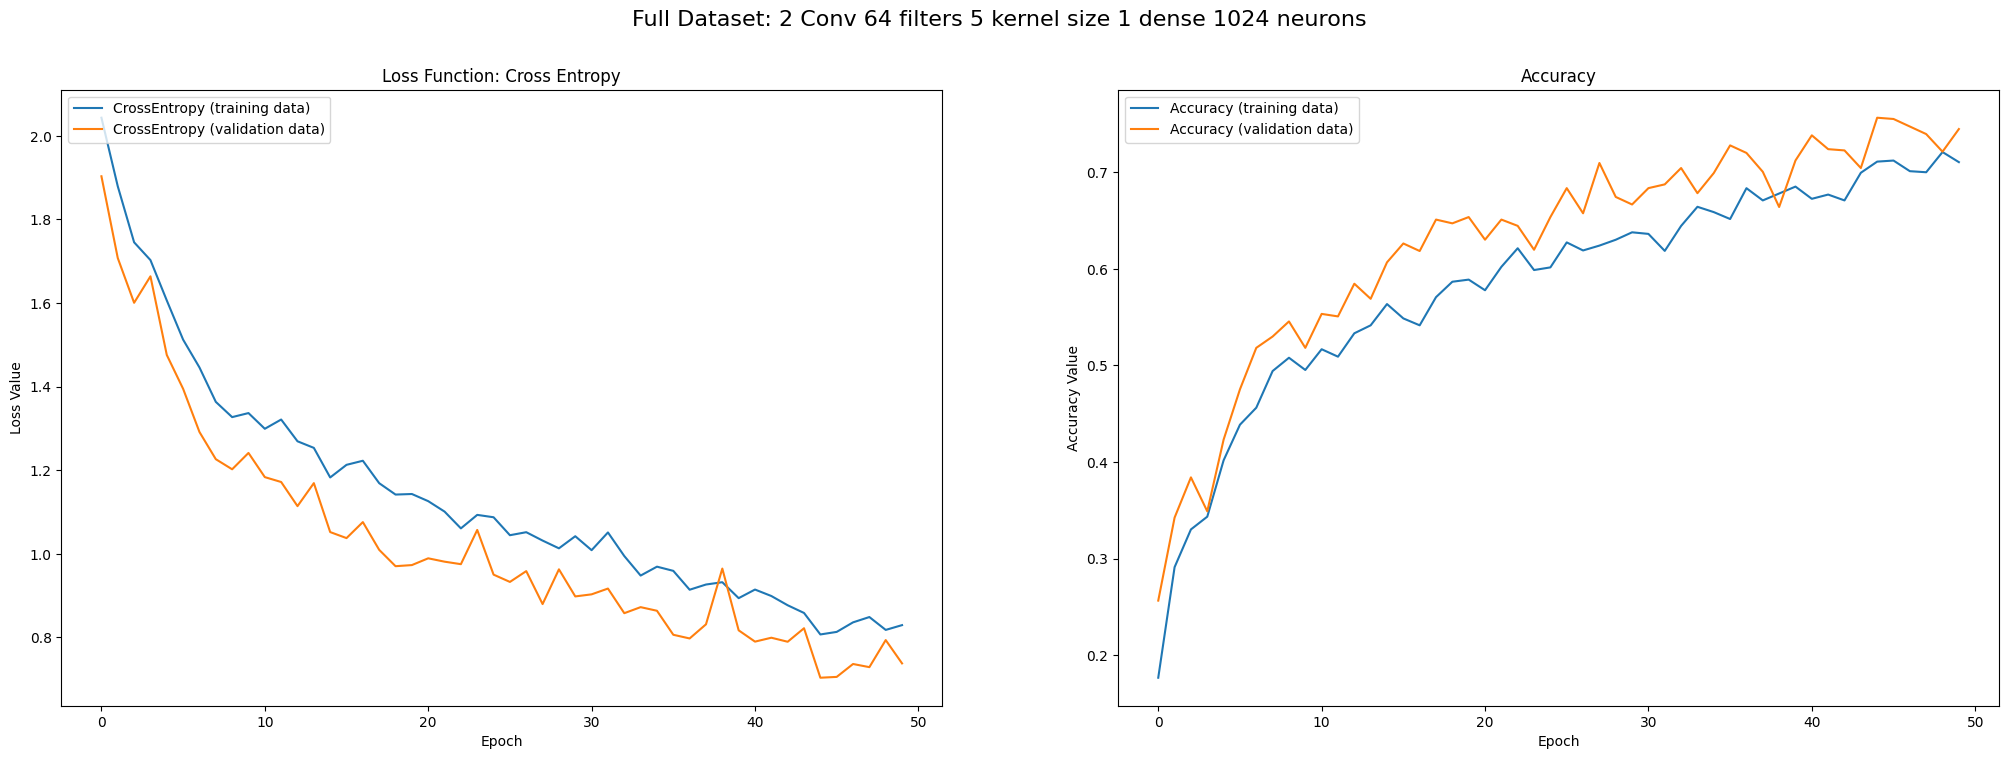

Train Accuracy: 0.7108  Train Loss: 0.8070
Test Accuracy: 0.7460  Test Loss: 0.7354


In [10]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

In [11]:
N_CONV  = 4
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 10s 320ms/step - loss: 2.0588 - accuracy: 0.1458 - val_loss: 1.9715 - val_accuracy: 0.1393
Epoch 2/50
29/29 [==============================] - 9s 333ms/step - loss: 1.9614 - accuracy: 0.1888 - val_loss: 1.7760 - val_accuracy: 0.2969
Epoch 3/50
29/29 [==============================] - 9s 304ms/step - loss: 1.8029 - accuracy: 0.3291 - val_loss: 1.7561 - val_accuracy: 0.2917
Epoch 4/50
29/29 [==============================] - 9s 319ms/step - loss: 1.6107 - accuracy: 0.3772 - val_loss: 1.5345 - val_accuracy: 0.3451
Epoch 5/50
29/29 [==============================] - 8s 263ms/step - loss: 1.5160 - accuracy: 0.3963 - val_loss: 1.3368 - val_accuracy: 0.4805
Epoch 6/50
29/29 [==============================] - 10s 364ms/step - loss: 1.4788 - accuracy: 0.4150 - val_loss: 1.3599 - val_accuracy: 0.4492
Epoch 7/50
29/29 [==============================] - 9s 325ms/step - loss: 1.3944 - accuracy: 0.4750 - val_loss: 1.3850 - val_accuracy: 0.4427
Epoc

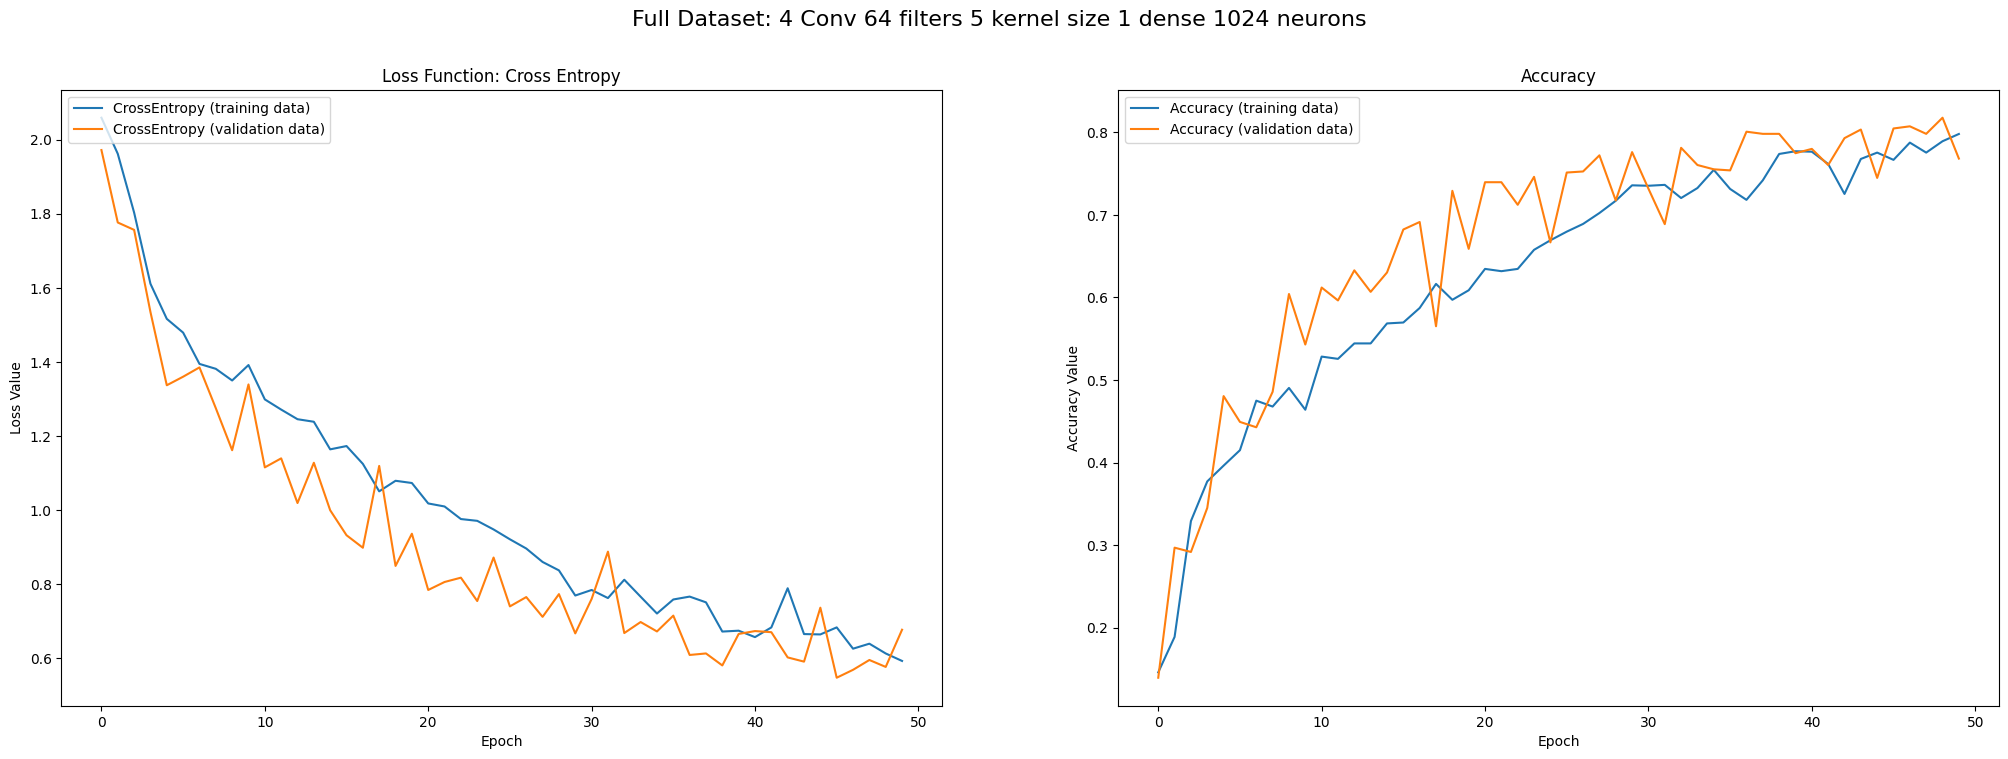

Train Accuracy: 0.7666  Train Loss: 0.6570
Test Accuracy: 0.7670  Test Loss: 0.6827


In [12]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

In [13]:
N_CONV  = 8
CONV = 64
KERNEL = 5
N_DENSE = 1
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 10s 331ms/step - loss: 2.0828 - accuracy: 0.1475 - val_loss: 2.0733 - val_accuracy: 0.1458
Epoch 2/50
29/29 [==============================] - 8s 278ms/step - loss: 2.0721 - accuracy: 0.1480 - val_loss: 1.9608 - val_accuracy: 0.2396
Epoch 3/50
29/29 [==============================] - 8s 268ms/step - loss: 2.0555 - accuracy: 0.1723 - val_loss: 1.9983 - val_accuracy: 0.2370
Epoch 4/50
29/29 [==============================] - 9s 311ms/step - loss: 2.0425 - accuracy: 0.1855 - val_loss: 2.0458 - val_accuracy: 0.1888
Epoch 5/50
29/29 [==============================] - 8s 292ms/step - loss: 2.0276 - accuracy: 0.1833 - val_loss: 1.9655 - val_accuracy: 0.2734
Epoch 6/50
29/29 [==============================] - 8s 259ms/step - loss: 1.9264 - accuracy: 0.2510 - val_loss: 1.8223 - val_accuracy: 0.2839
Epoch 7/50
29/29 [==============================] - 8s 288ms/step - loss: 1.8123 - accuracy: 0.2977 - val_loss: 1.7904 - val_accuracy: 0.3021
Epoch

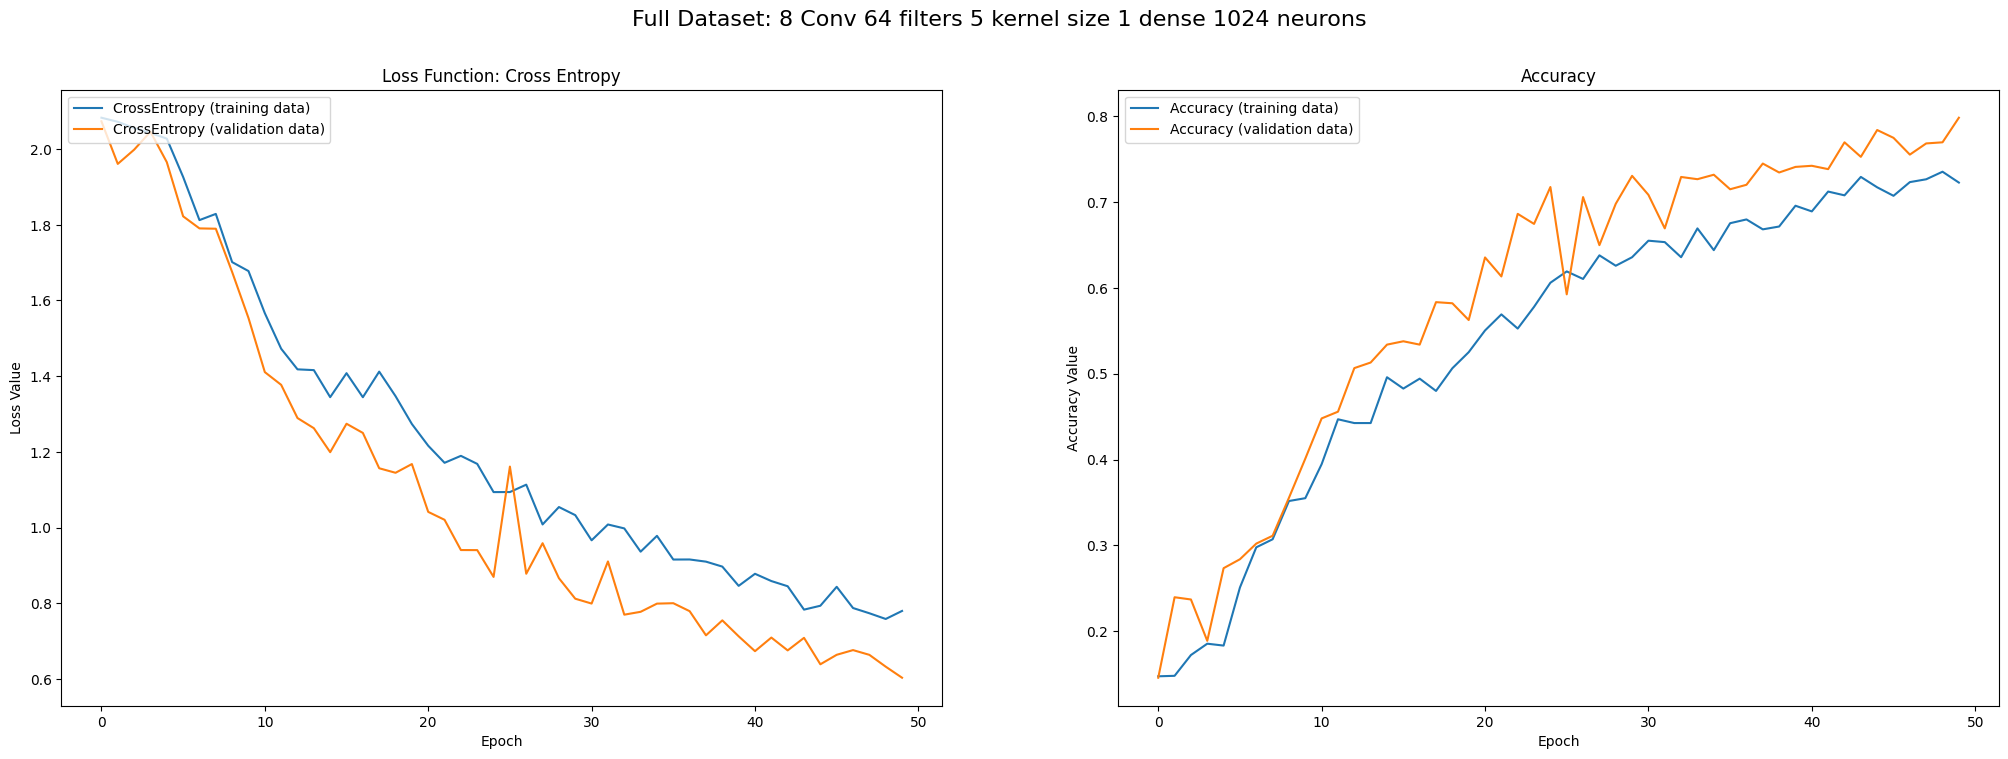

Train Accuracy: 0.7528  Train Loss: 0.7195
Test Accuracy: 0.7931  Test Loss: 0.6139


In [14]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

## Checking Dense Layers

In [15]:
N_CONV  = 4
CONV = 64
KERNEL = 5
N_DENSE = 2
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 10s 342ms/step - loss: 2.0572 - accuracy: 0.1442 - val_loss: 1.9807 - val_accuracy: 0.1393
Epoch 2/50
29/29 [==============================] - 9s 313ms/step - loss: 1.9897 - accuracy: 0.1871 - val_loss: 1.8366 - val_accuracy: 0.2487
Epoch 3/50
29/29 [==============================] - 9s 296ms/step - loss: 1.8835 - accuracy: 0.2438 - val_loss: 1.7513 - val_accuracy: 0.3086
Epoch 4/50
29/29 [==============================] - 9s 300ms/step - loss: 1.8483 - accuracy: 0.2752 - val_loss: 1.6967 - val_accuracy: 0.3385
Epoch 5/50
29/29 [==============================] - 9s 311ms/step - loss: 1.8304 - accuracy: 0.2906 - val_loss: 1.7267 - val_accuracy: 0.3047
Epoch 6/50
29/29 [==============================] - 9s 295ms/step - loss: 1.7199 - accuracy: 0.3451 - val_loss: 1.6402 - val_accuracy: 0.3633
Epoch 7/50
29/29 [==============================] - 9s 298ms/step - loss: 1.6704 - accuracy: 0.3654 - val_loss: 1.6155 - val_accuracy: 0.3620
Epoch

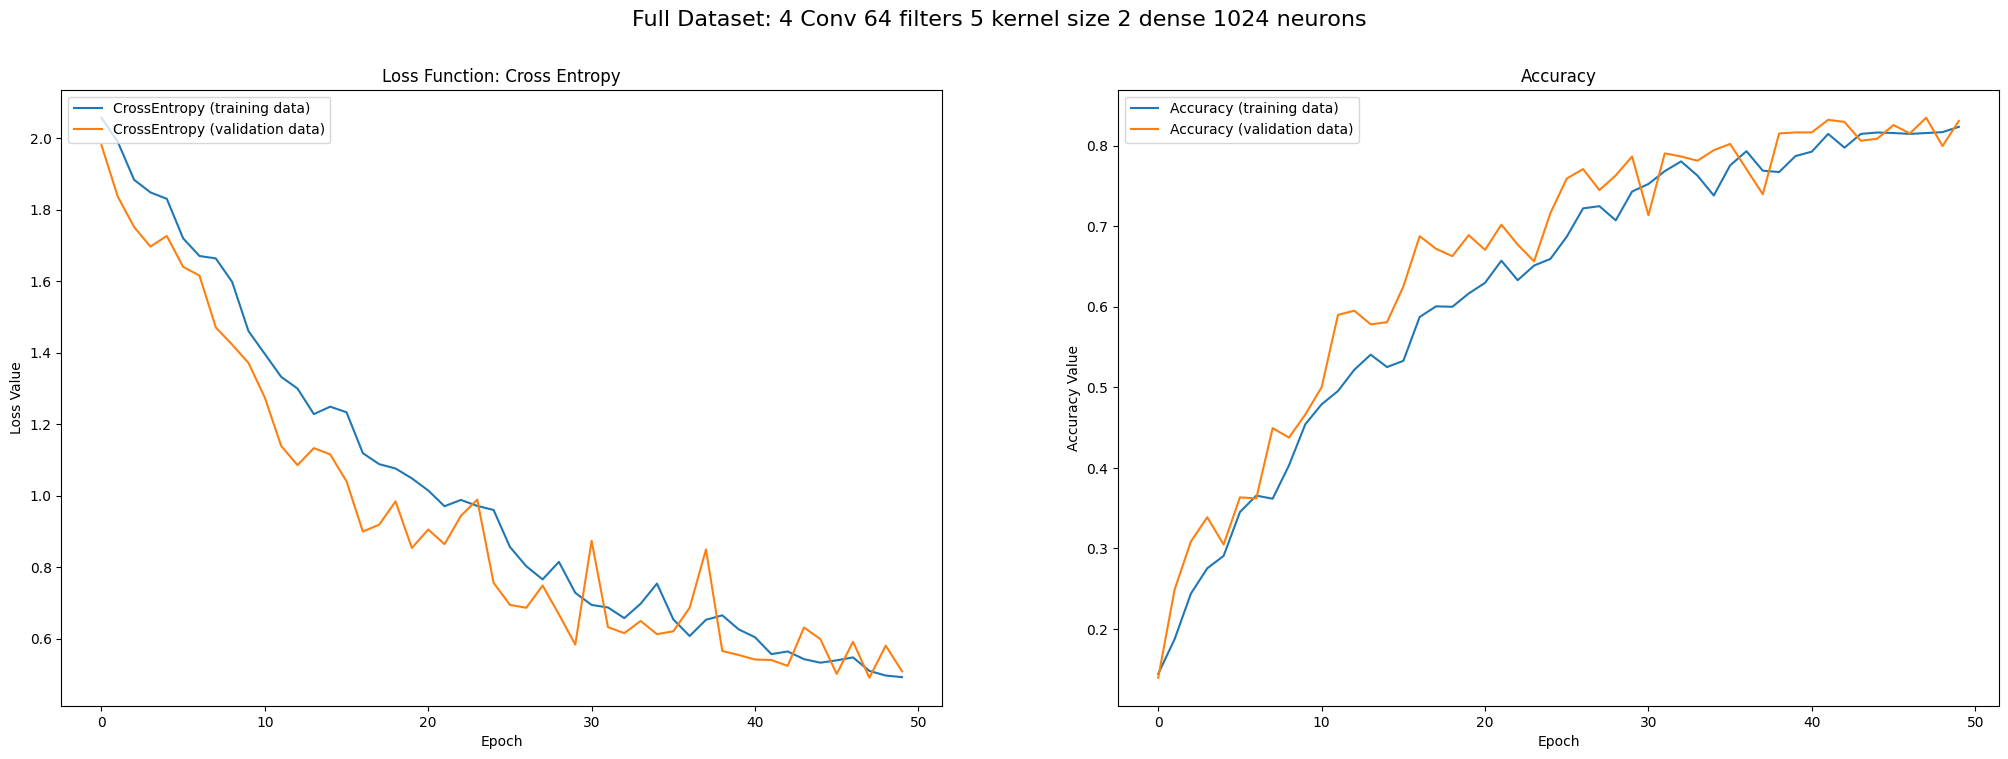

Train Accuracy: 0.8410  Train Loss: 0.4555
Test Accuracy: 0.8290  Test Loss: 0.5157


In [16]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

In [17]:
N_CONV  = 4
CONV = 64
KERNEL = 5
N_DENSE = 4
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 9s 293ms/step - loss: 2.1043 - accuracy: 0.1563 - val_loss: 2.0682 - val_accuracy: 0.1458
Epoch 2/50
29/29 [==============================] - 9s 309ms/step - loss: 1.9960 - accuracy: 0.1822 - val_loss: 1.8838 - val_accuracy: 0.2734
Epoch 3/50
29/29 [==============================] - 8s 272ms/step - loss: 1.9568 - accuracy: 0.2108 - val_loss: 1.8768 - val_accuracy: 0.2005
Epoch 4/50
29/29 [==============================] - 9s 300ms/step - loss: 1.8771 - accuracy: 0.2449 - val_loss: 1.8867 - val_accuracy: 0.2760
Epoch 5/50
29/29 [==============================] - 9s 301ms/step - loss: 1.8209 - accuracy: 0.2911 - val_loss: 1.6755 - val_accuracy: 0.3385
Epoch 6/50
29/29 [==============================] - 8s 268ms/step - loss: 1.7575 - accuracy: 0.3176 - val_loss: 1.6892 - val_accuracy: 0.3346
Epoch 7/50
29/29 [==============================] - 9s 301ms/step - loss: 1.7286 - accuracy: 0.3434 - val_loss: 1.7337 - val_accuracy: 0.3151
Epoch 

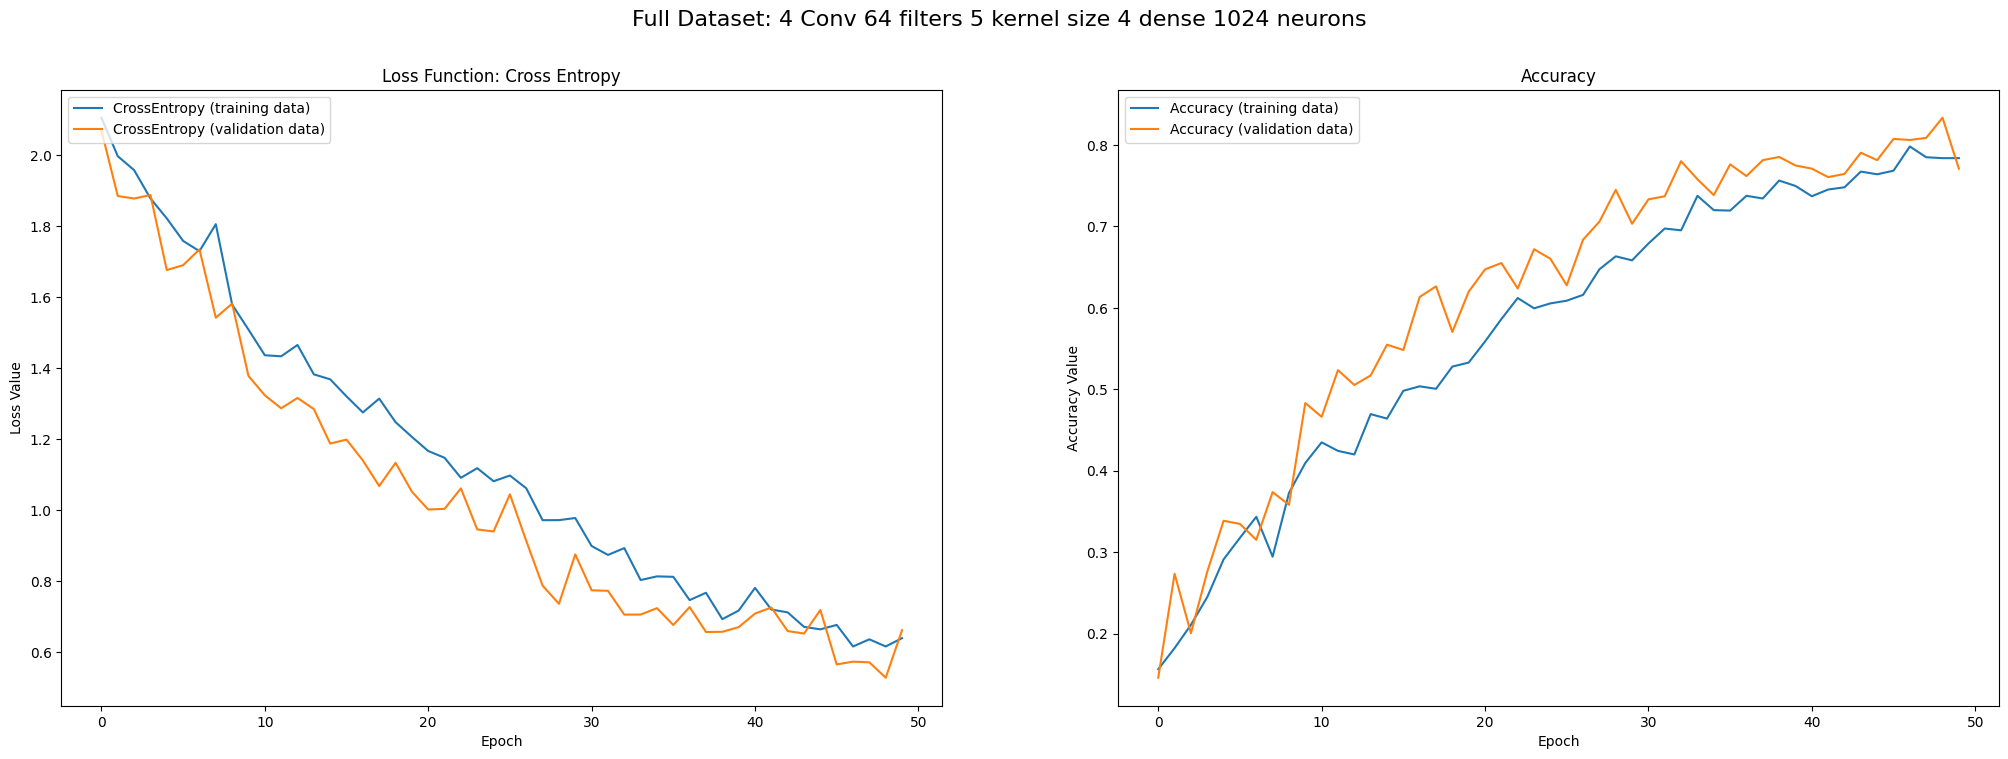

Train Accuracy: 0.7746  Train Loss: 0.6397
Test Accuracy: 0.7745  Test Loss: 0.6545


In [18]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

## Checking Number of Filters

In [19]:
N_CONV  = 4
CONV = 32
KERNEL = 5
N_DENSE = 2
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 10s 314ms/step - loss: 2.0670 - accuracy: 0.1398 - val_loss: 2.0446 - val_accuracy: 0.2188
Epoch 2/50
29/29 [==============================] - 10s 344ms/step - loss: 1.9744 - accuracy: 0.2135 - val_loss: 1.9182 - val_accuracy: 0.2148
Epoch 3/50
29/29 [==============================] - 8s 259ms/step - loss: 1.8662 - accuracy: 0.2581 - val_loss: 1.7708 - val_accuracy: 0.2930
Epoch 4/50
29/29 [==============================] - 7s 250ms/step - loss: 1.8012 - accuracy: 0.3016 - val_loss: 1.6605 - val_accuracy: 0.3568
Epoch 5/50
29/29 [==============================] - 8s 277ms/step - loss: 1.7240 - accuracy: 0.3583 - val_loss: 1.5783 - val_accuracy: 0.3828
Epoch 6/50
29/29 [==============================] - 10s 342ms/step - loss: 1.6188 - accuracy: 0.3786 - val_loss: 1.4979 - val_accuracy: 0.4193
Epoch 7/50
29/29 [==============================] - 8s 292ms/step - loss: 1.5301 - accuracy: 0.4078 - val_loss: 1.3779 - val_accuracy: 0.4570
Epo

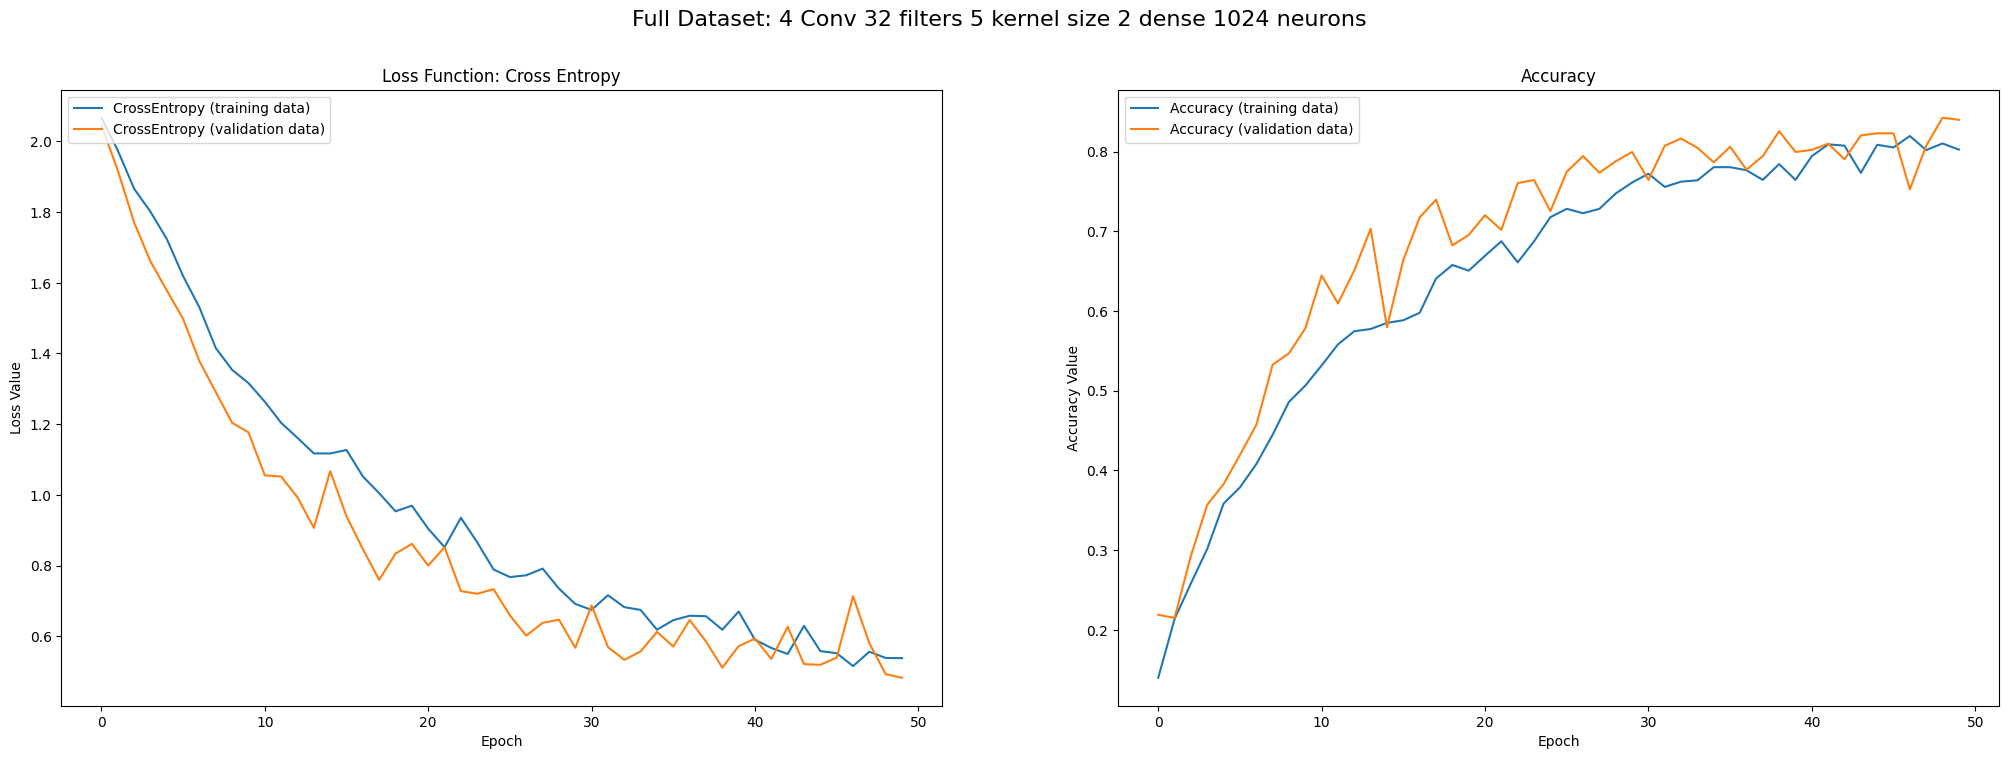

Train Accuracy: 0.8171  Train Loss: 0.5079
Test Accuracy: 0.8364  Test Loss: 0.4903


In [20]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

In [21]:
N_CONV  = 4
CONV = 128
KERNEL = 5
N_DENSE = 2
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 11s 349ms/step - loss: 2.0634 - accuracy: 0.1563 - val_loss: 1.9790 - val_accuracy: 0.2044
Epoch 2/50
29/29 [==============================] - 9s 307ms/step - loss: 1.9609 - accuracy: 0.1970 - val_loss: 1.8617 - val_accuracy: 0.2214
Epoch 3/50
29/29 [==============================] - 10s 357ms/step - loss: 1.8720 - accuracy: 0.2378 - val_loss: 1.9416 - val_accuracy: 0.2135
Epoch 4/50
29/29 [==============================] - 8s 281ms/step - loss: 1.7825 - accuracy: 0.3170 - val_loss: 1.7931 - val_accuracy: 0.2773
Epoch 5/50
29/29 [==============================] - 9s 298ms/step - loss: 1.8040 - accuracy: 0.2840 - val_loss: 1.5749 - val_accuracy: 0.3633
Epoch 6/50
29/29 [==============================] - 9s 324ms/step - loss: 1.8367 - accuracy: 0.3021 - val_loss: 1.7314 - val_accuracy: 0.3190
Epoch 7/50
29/29 [==============================] - 8s 282ms/step - loss: 1.7237 - accuracy: 0.3500 - val_loss: 1.6313 - val_accuracy: 0.4089
Epoc

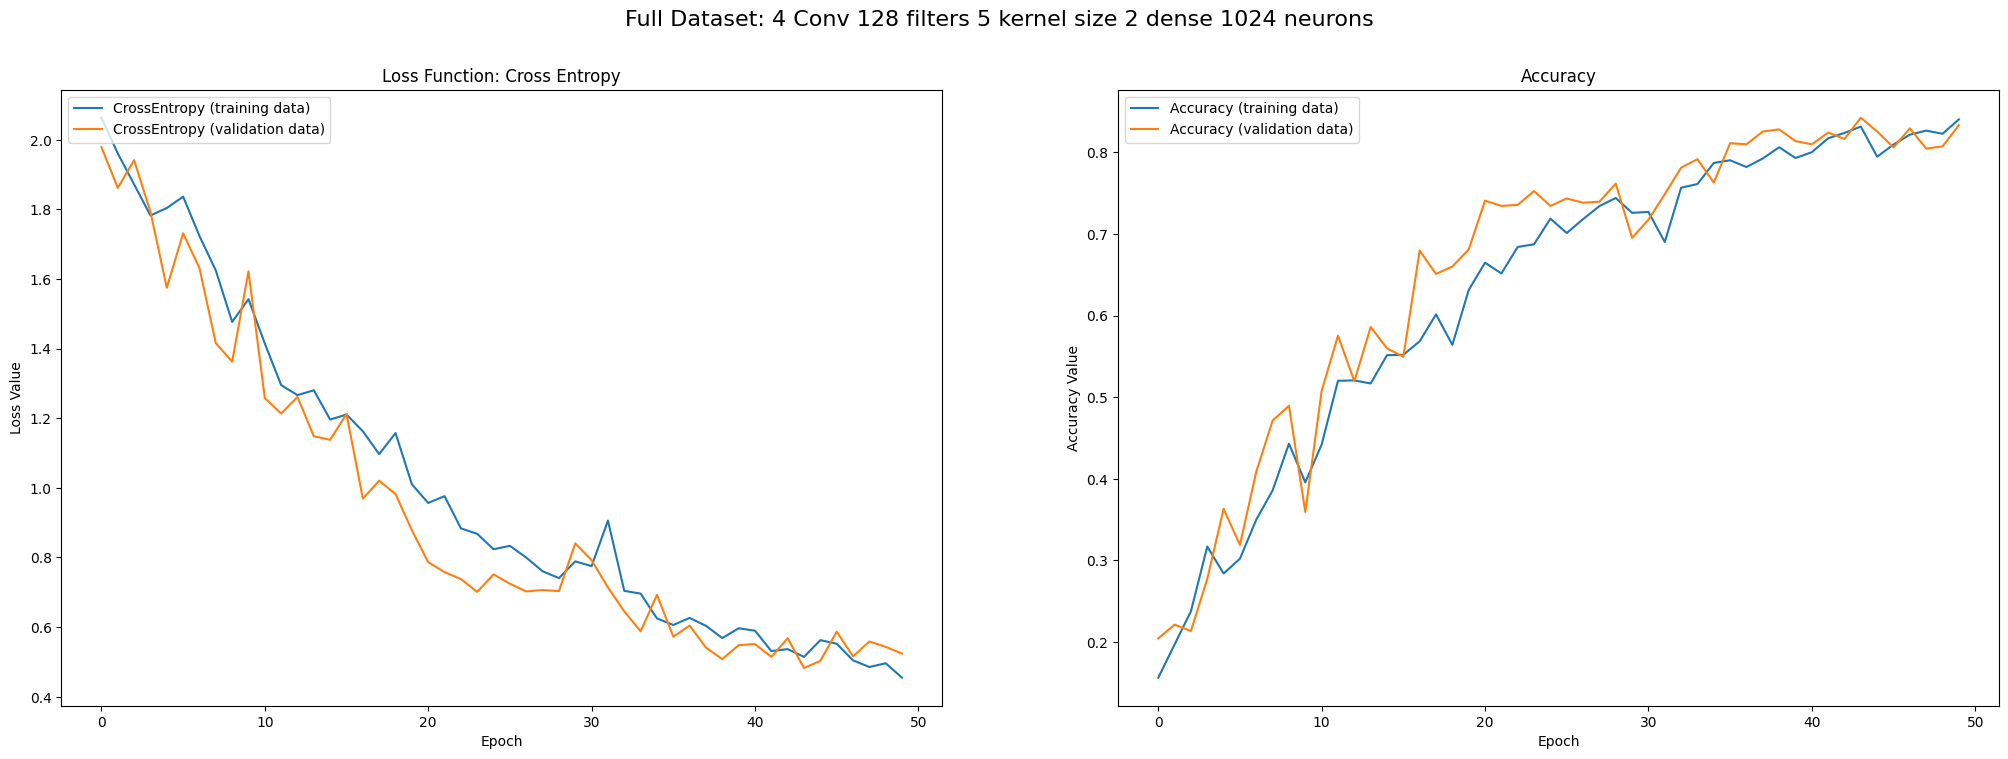

Train Accuracy: 0.8352  Train Loss: 0.4737
Test Accuracy: 0.8340  Test Loss: 0.5239


In [22]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

In [23]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 17s 445ms/step - loss: 2.0777 - accuracy: 0.1502 - val_loss: 2.0530 - val_accuracy: 0.1589
Epoch 2/50
29/29 [==============================] - 11s 392ms/step - loss: 2.0125 - accuracy: 0.1855 - val_loss: 1.9401 - val_accuracy: 0.2279
Epoch 3/50
29/29 [==============================] - 11s 365ms/step - loss: 1.9594 - accuracy: 0.2108 - val_loss: 1.9622 - val_accuracy: 0.2500
Epoch 4/50
29/29 [==============================] - 12s 402ms/step - loss: 1.9010 - accuracy: 0.2565 - val_loss: 1.8475 - val_accuracy: 0.2865
Epoch 5/50
29/29 [==============================] - 11s 385ms/step - loss: 1.8279 - accuracy: 0.2900 - val_loss: 1.7529 - val_accuracy: 0.3086
Epoch 6/50
29/29 [==============================] - 12s 393ms/step - loss: 1.7593 - accuracy: 0.3132 - val_loss: 1.6693 - val_accuracy: 0.3516
Epoch 7/50
29/29 [==============================] - 11s 357ms/step - loss: 1.7431 - accuracy: 0.3181 - val_loss: 1.7483 - val_accuracy: 0.3060

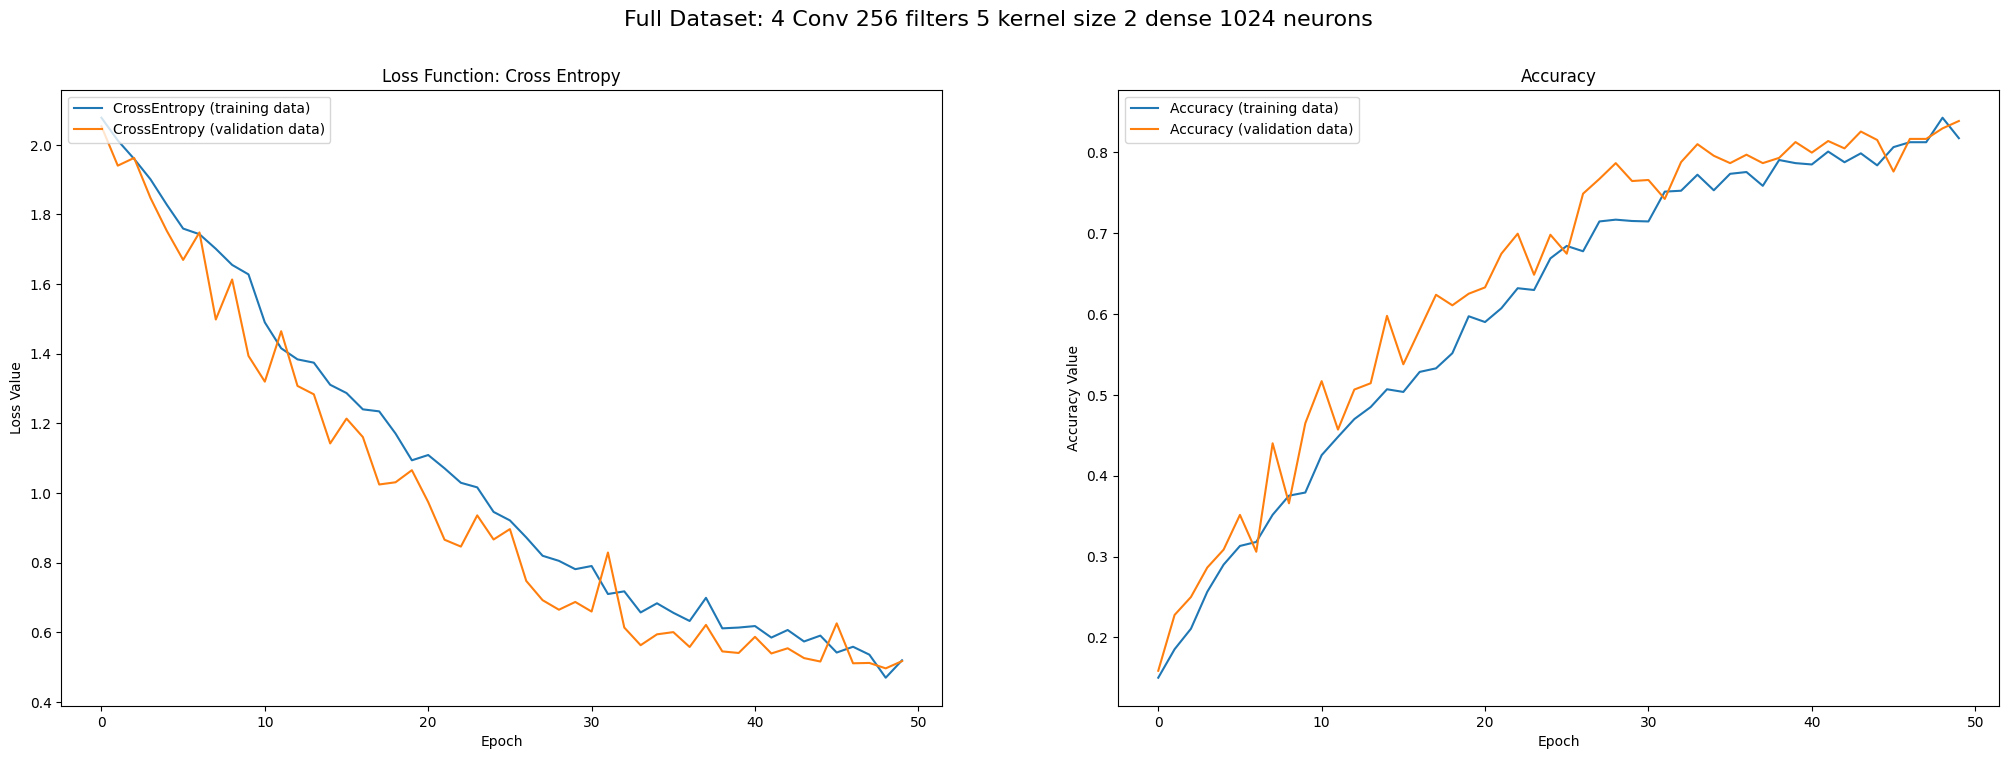

Train Accuracy: 0.8192  Train Loss: 0.5021
Test Accuracy: 0.8364  Test Loss: 0.5273


In [24]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

## Checking Regularization

In [31]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
MAX_POOLING = True

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 8s 283ms/step - loss: 2.0629 - accuracy: 0.1497 - val_loss: 1.9777 - val_accuracy: 0.2344
Epoch 2/50
29/29 [==============================] - 9s 309ms/step - loss: 2.0038 - accuracy: 0.1877 - val_loss: 1.9539 - val_accuracy: 0.1771
Epoch 3/50
29/29 [==============================] - 10s 330ms/step - loss: 1.9171 - accuracy: 0.2124 - val_loss: 1.9412 - val_accuracy: 0.2370
Epoch 4/50
29/29 [==============================] - 9s 298ms/step - loss: 1.8357 - accuracy: 0.2675 - val_loss: 1.8252 - val_accuracy: 0.2578
Epoch 5/50
29/29 [==============================] - 8s 274ms/step - loss: 1.7834 - accuracy: 0.3148 - val_loss: 1.6157 - val_accuracy: 0.3750
Epoch 6/50
29/29 [==============================] - 9s 294ms/step - loss: 1.7106 - accuracy: 0.3412 - val_loss: 1.6436 - val_accuracy: 0.3555
Epoch 7/50
29/29 [==============================] - 8s 290ms/step - loss: 1.5468 - accuracy: 0.4177 - val_loss: 1.5024 - val_accuracy: 0.3516
Epoch

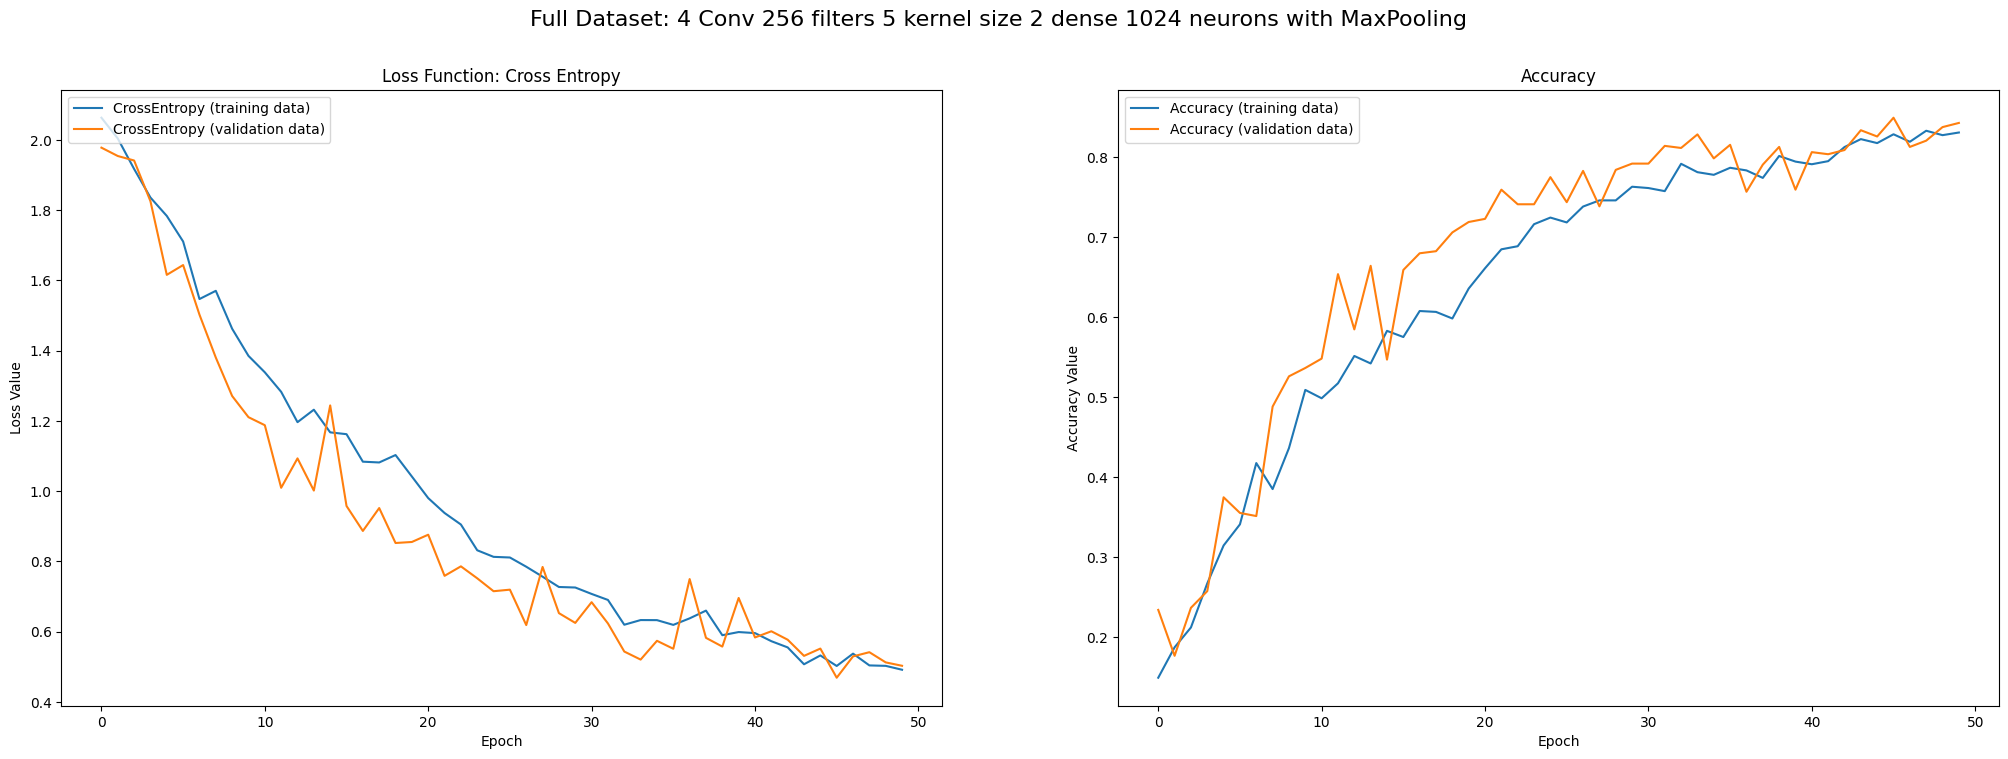

Train Accuracy: 0.8357  Train Loss: 0.4755
Test Accuracy: 0.8476  Test Loss: 0.4916


In [32]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons with MaxPooling".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

In [34]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
DROPOUT = True

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, dropout = DROPOUT, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 11s 378ms/step - loss: 2.0866 - accuracy: 0.1398 - val_loss: 2.1013 - val_accuracy: 0.1406
Epoch 2/50
29/29 [==============================] - 12s 426ms/step - loss: 2.0579 - accuracy: 0.1574 - val_loss: 2.0705 - val_accuracy: 0.1497
Epoch 3/50
29/29 [==============================] - 10s 352ms/step - loss: 2.0712 - accuracy: 0.1541 - val_loss: 2.0569 - val_accuracy: 0.1497
Epoch 4/50
29/29 [==============================] - 12s 399ms/step - loss: 2.0226 - accuracy: 0.1778 - val_loss: 1.8875 - val_accuracy: 0.2578
Epoch 5/50
29/29 [==============================] - 14s 468ms/step - loss: 1.9572 - accuracy: 0.2356 - val_loss: 1.8088 - val_accuracy: 0.2812
Epoch 6/50
29/29 [==============================] - 12s 400ms/step - loss: 1.8721 - accuracy: 0.2713 - val_loss: 1.8546 - val_accuracy: 0.2630
Epoch 7/50
29/29 [==============================] - 14s 476ms/step - loss: 1.8101 - accuracy: 0.3126 - val_loss: 1.8198 - val_accuracy: 0.2435

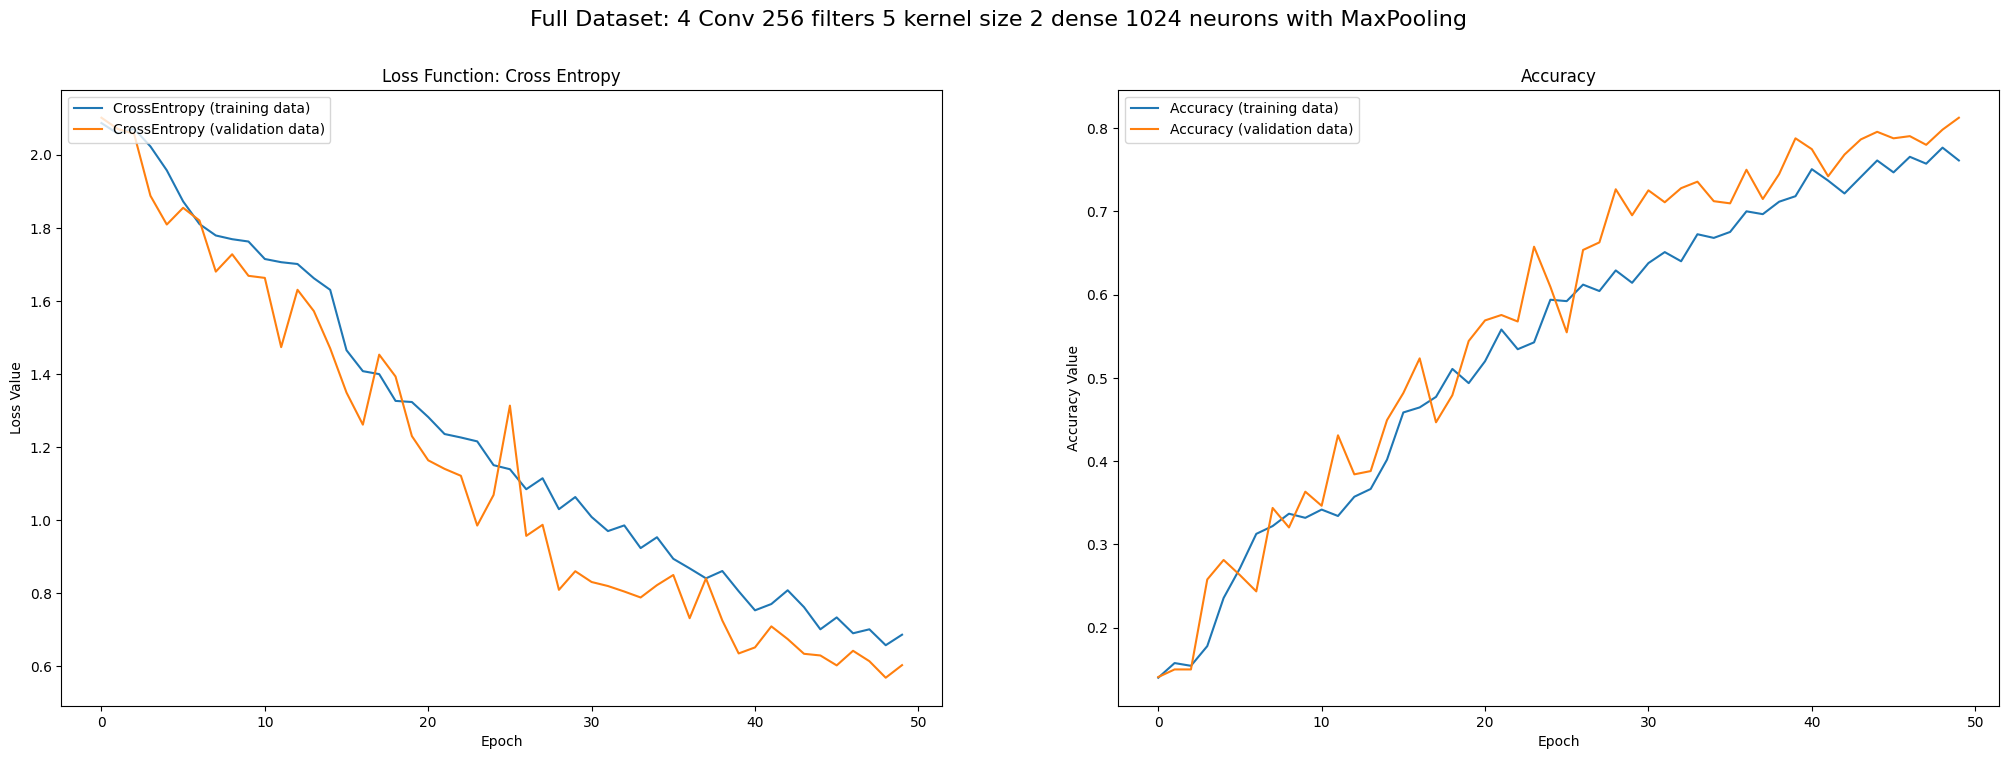

Train Accuracy: 0.7666  Train Loss: 0.6615
Test Accuracy: 0.8104  Test Loss: 0.6028


In [35]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons with 0.2 Dropout on FC".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

In [37]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
BATCH_NORM = True

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, batch_norm = BATCH_NORM, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 14s 461ms/step - loss: 2.3259 - accuracy: 0.3176 - val_loss: 4.4585 - val_accuracy: 0.1549
Epoch 2/50
29/29 [==============================] - 16s 562ms/step - loss: 1.6364 - accuracy: 0.4441 - val_loss: 3.8271 - val_accuracy: 0.1432
Epoch 3/50
29/29 [==============================] - 16s 530ms/step - loss: 1.4231 - accuracy: 0.5063 - val_loss: 2.8233 - val_accuracy: 0.2109
Epoch 4/50
29/29 [==============================] - 16s 542ms/step - loss: 1.2891 - accuracy: 0.5509 - val_loss: 2.2642 - val_accuracy: 0.2461
Epoch 5/50
29/29 [==============================] - 15s 486ms/step - loss: 1.2119 - accuracy: 0.5762 - val_loss: 4.0934 - val_accuracy: 0.1224
Epoch 6/50
29/29 [==============================] - 15s 513ms/step - loss: 1.2006 - accuracy: 0.5784 - val_loss: 3.0547 - val_accuracy: 0.1328
Epoch 7/50
29/29 [==============================] - 14s 465ms/step - loss: 1.0871 - accuracy: 0.6219 - val_loss: 5.0452 - val_accuracy: 0.1276

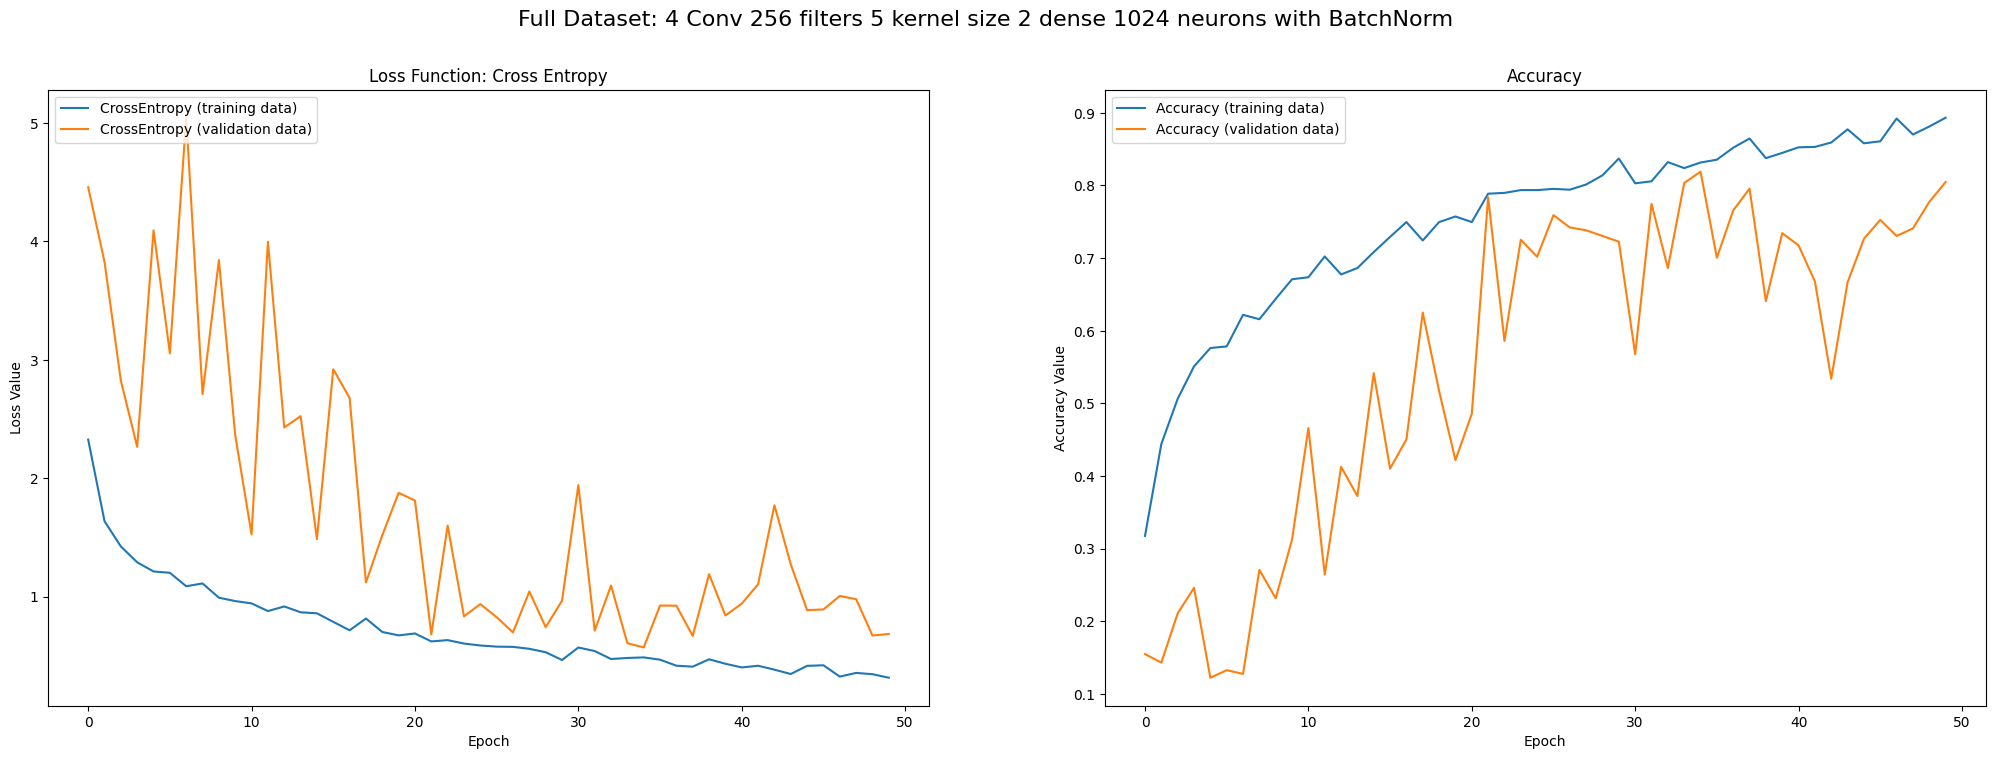

Train Accuracy: 0.8017  Train Loss: 0.6198
Test Accuracy: 0.8017  Test Loss: 0.6922


In [38]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons with BatchNorm".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

In [42]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
MAX_POOLING = True
DROPOUT = True

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, dropout = DROPOUT, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 8s 291ms/step - loss: 2.0843 - accuracy: 0.1436 - val_loss: 2.0580 - val_accuracy: 0.1471
Epoch 2/50
29/29 [==============================] - 9s 303ms/step - loss: 2.0440 - accuracy: 0.1569 - val_loss: 2.0173 - val_accuracy: 0.1953
Epoch 3/50
29/29 [==============================] - 8s 270ms/step - loss: 2.0140 - accuracy: 0.1794 - val_loss: 1.9872 - val_accuracy: 0.1719
Epoch 4/50
29/29 [==============================] - 9s 317ms/step - loss: 1.9106 - accuracy: 0.2223 - val_loss: 1.8045 - val_accuracy: 0.2773
Epoch 5/50
29/29 [==============================] - 9s 295ms/step - loss: 1.8485 - accuracy: 0.2620 - val_loss: 1.7919 - val_accuracy: 0.3008
Epoch 6/50
29/29 [==============================] - 9s 316ms/step - loss: 1.7728 - accuracy: 0.2911 - val_loss: 1.4782 - val_accuracy: 0.4258
Epoch 7/50
29/29 [==============================] - 9s 299ms/step - loss: 1.5692 - accuracy: 0.3764 - val_loss: 1.3960 - val_accuracy: 0.4453
Epoch 

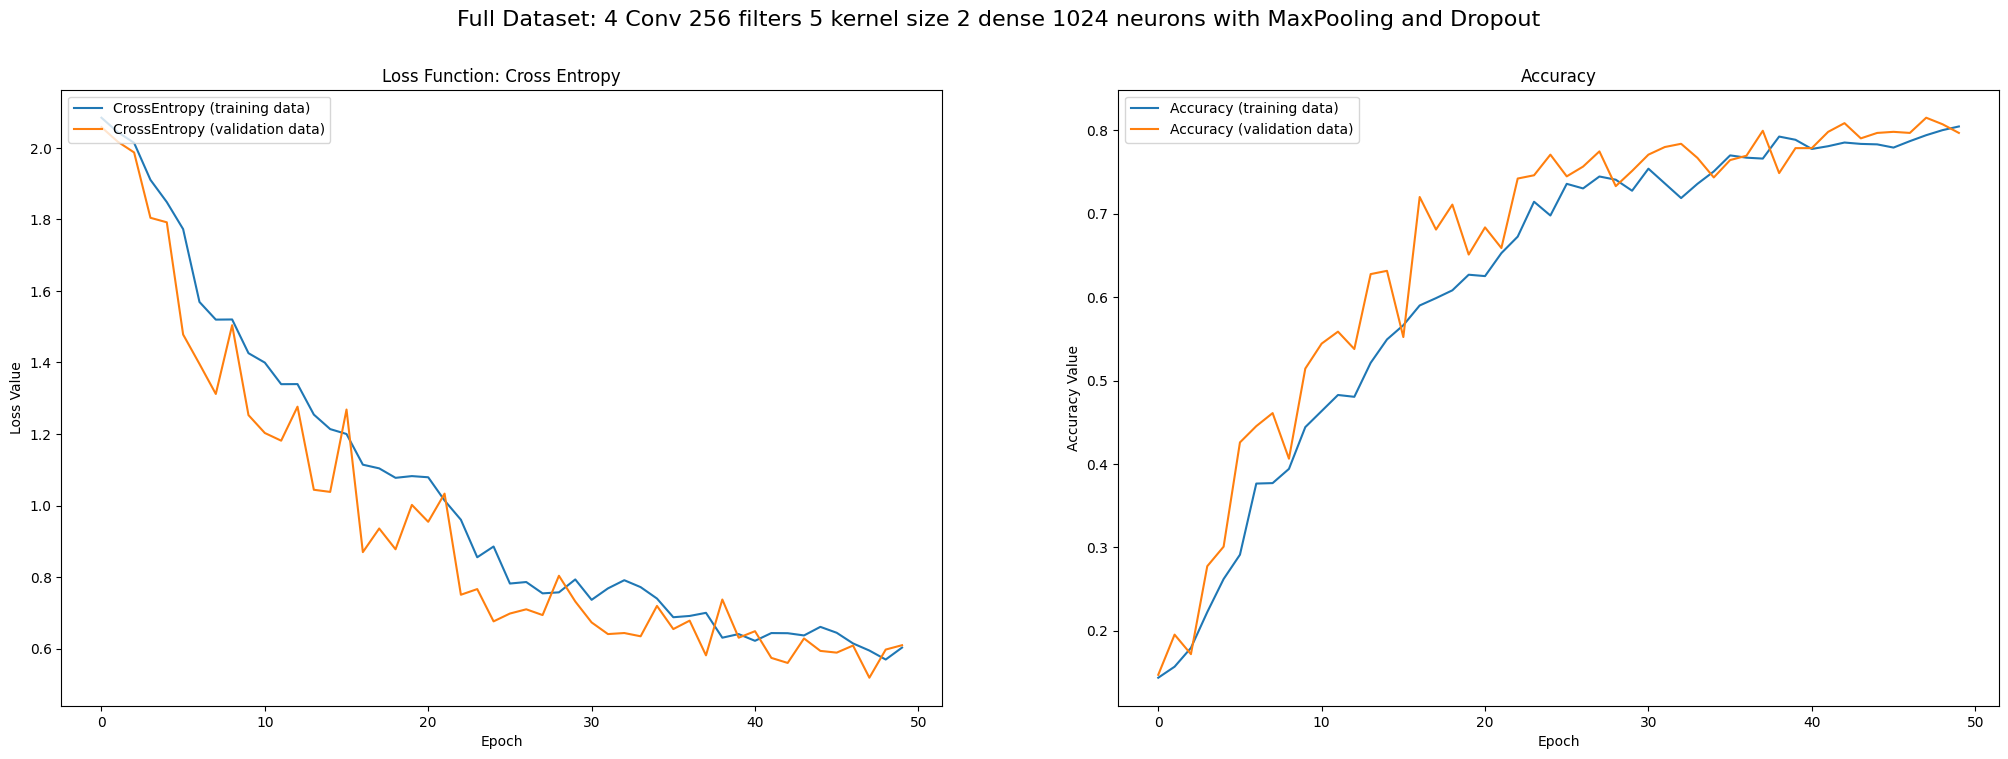

Train Accuracy: 0.8171  Train Loss: 0.5275
Test Accuracy: 0.7980  Test Loss: 0.6075


In [43]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons with MaxPooling and Dropout".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

In [44]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
MAX_POOLING = True
BATCH_NORM = True

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, batch_norm = BATCH_NORM, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 8s 279ms/step - loss: 2.4086 - accuracy: 0.3313 - val_loss: 4.2616 - val_accuracy: 0.1484
Epoch 2/50
29/29 [==============================] - 8s 284ms/step - loss: 1.5129 - accuracy: 0.4843 - val_loss: 2.0934 - val_accuracy: 0.2240
Epoch 3/50
29/29 [==============================] - 8s 291ms/step - loss: 1.4143 - accuracy: 0.4783 - val_loss: 2.0435 - val_accuracy: 0.2331
Epoch 4/50
29/29 [==============================] - 9s 305ms/step - loss: 1.2180 - accuracy: 0.5773 - val_loss: 1.8776 - val_accuracy: 0.2682
Epoch 5/50
29/29 [==============================] - 8s 286ms/step - loss: 1.1630 - accuracy: 0.5834 - val_loss: 2.0929 - val_accuracy: 0.2747
Epoch 6/50
29/29 [==============================] - 9s 307ms/step - loss: 1.1208 - accuracy: 0.5955 - val_loss: 2.1879 - val_accuracy: 0.2396
Epoch 7/50
29/29 [==============================] - 9s 300ms/step - loss: 1.0577 - accuracy: 0.6296 - val_loss: 2.2807 - val_accuracy: 0.2604
Epoch 

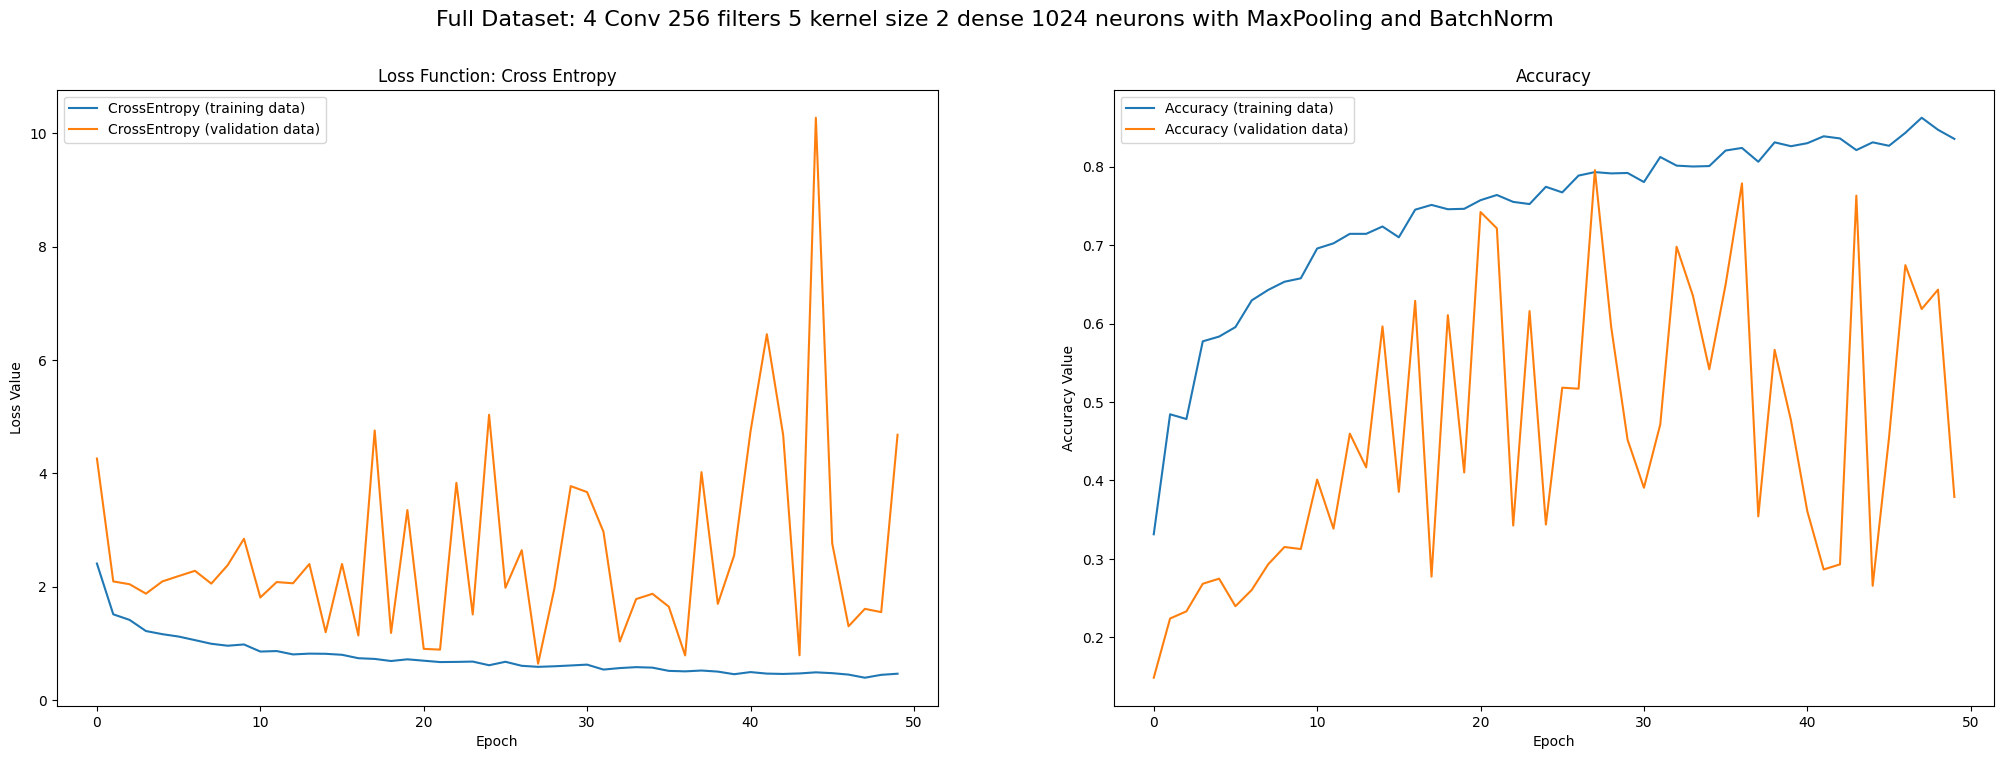

Train Accuracy: 0.3971  Train Loss: 4.4133
Test Accuracy: 0.3804  Test Loss: 4.6534


In [45]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons with MaxPooling and BatchNorm".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

In [46]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
DROPOUT = True
BATCH_NORM = True

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, dropout = DROPOUT, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 9s 297ms/step - loss: 2.0783 - accuracy: 0.1442 - val_loss: 1.9149 - val_accuracy: 0.1667
Epoch 2/50
29/29 [==============================] - 9s 294ms/step - loss: 1.9683 - accuracy: 0.1816 - val_loss: 2.0118 - val_accuracy: 0.1758
Epoch 3/50
29/29 [==============================] - 8s 260ms/step - loss: 1.9175 - accuracy: 0.2113 - val_loss: 1.7852 - val_accuracy: 0.2357
Epoch 4/50
29/29 [==============================] - 8s 258ms/step - loss: 1.8474 - accuracy: 0.2427 - val_loss: 2.0676 - val_accuracy: 0.2826
Epoch 5/50
29/29 [==============================] - 9s 292ms/step - loss: 1.8009 - accuracy: 0.2974 - val_loss: 1.7626 - val_accuracy: 0.3112
Epoch 6/50
29/29 [==============================] - 8s 284ms/step - loss: 1.7393 - accuracy: 0.3308 - val_loss: 1.9263 - val_accuracy: 0.3060
Epoch 7/50
29/29 [==============================] - 8s 291ms/step - loss: 1.6740 - accuracy: 0.3533 - val_loss: 1.4179 - val_accuracy: 0.4089
Epoch 

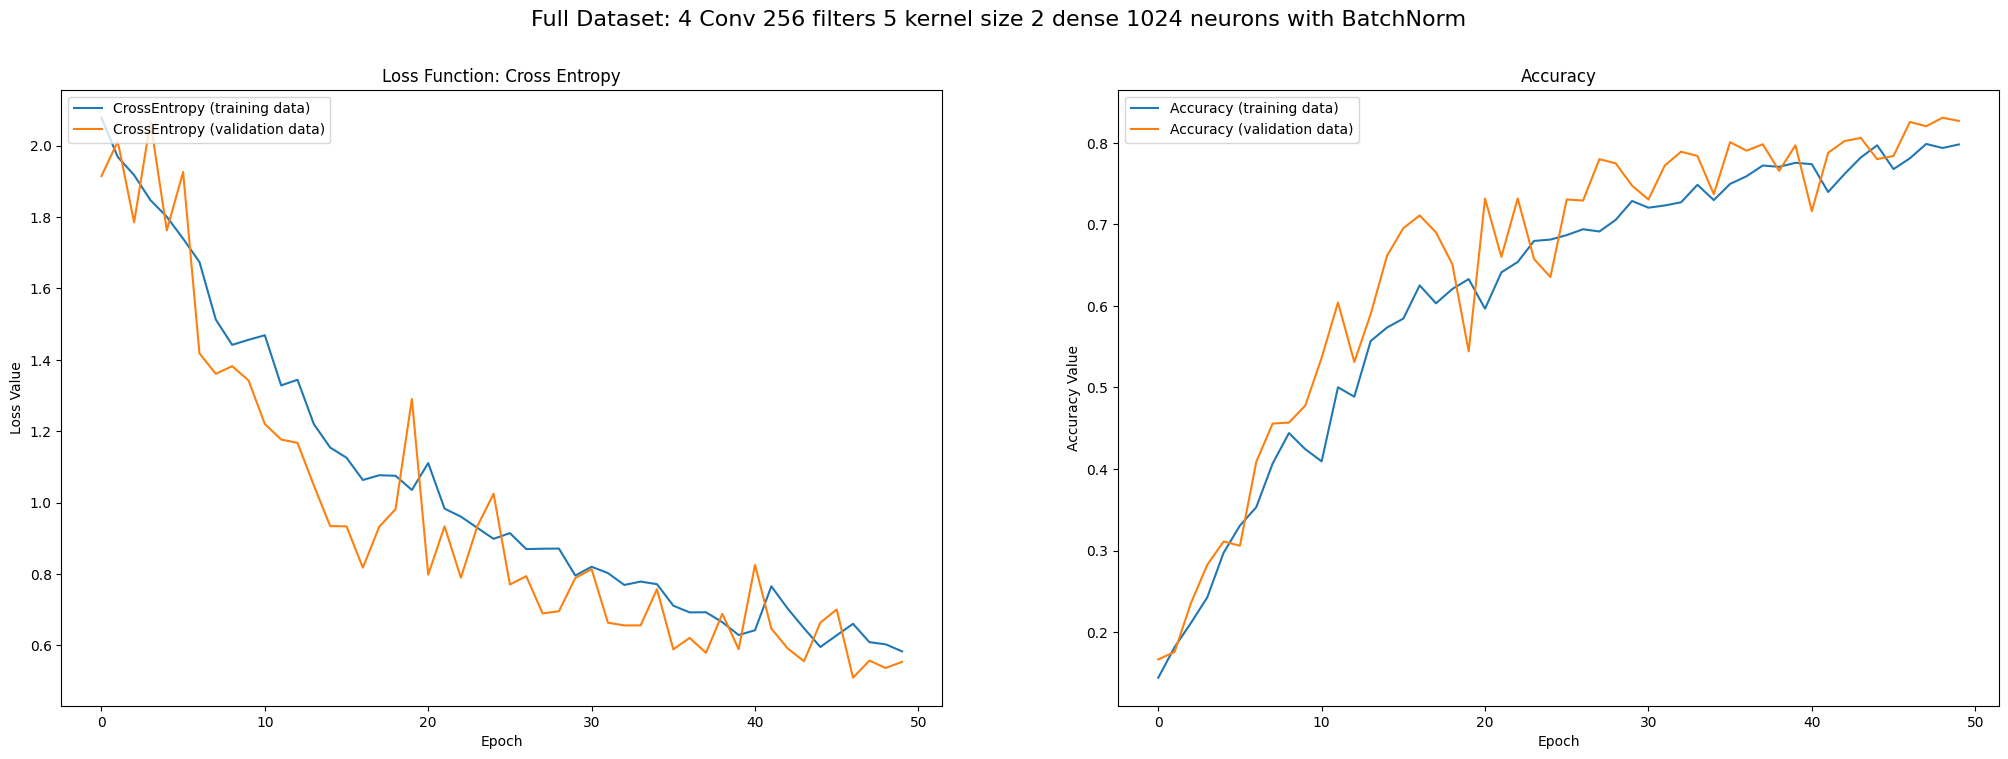

Train Accuracy: 0.8320  Train Loss: 0.5088
Test Accuracy: 0.8265  Test Loss: 0.5559


In [47]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons with BatchNorm".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))

In [48]:
N_CONV  = 4
CONV = 256
KERNEL = 5
N_DENSE = 2
DENSE = 1024
DROPOUT = True
BATCH_NORM = True
MAX_POOLING = True

tf.keras.backend.clear_session()
gc.collect()

model = build_model(n_conv = N_CONV, kernel_size= KERNEL, conv = CONV, n_dense = N_DENSE, dense = DENSE, max_pool = MAX_POOLING, dropout = DROPOUT, batch_norm = BATCH_NORM, opt = "adam")
history = model.fit(train_big,steps_per_epoch=train_big.samples // BATCH_SIZE, epochs=50, validation_data=test_big, validation_steps=test_big.samples // BATCH_SIZE)

Epoch 1/50
29/29 [==============================] - 9s 304ms/step - loss: 2.3405 - accuracy: 0.3032 - val_loss: 5.4225 - val_accuracy: 0.1406
Epoch 2/50
29/29 [==============================] - 9s 301ms/step - loss: 1.6670 - accuracy: 0.4474 - val_loss: 2.2529 - val_accuracy: 0.2826
Epoch 3/50
29/29 [==============================] - 10s 342ms/step - loss: 1.4168 - accuracy: 0.5096 - val_loss: 2.0189 - val_accuracy: 0.3021
Epoch 4/50
29/29 [==============================] - 8s 275ms/step - loss: 1.2958 - accuracy: 0.5614 - val_loss: 3.3594 - val_accuracy: 0.1719
Epoch 5/50
29/29 [==============================] - 9s 283ms/step - loss: 1.2190 - accuracy: 0.6059 - val_loss: 3.1523 - val_accuracy: 0.2227
Epoch 6/50
29/29 [==============================] - 8s 268ms/step - loss: 1.1891 - accuracy: 0.6087 - val_loss: 3.0912 - val_accuracy: 0.1823
Epoch 7/50
29/29 [==============================] - 8s 274ms/step - loss: 1.0541 - accuracy: 0.6549 - val_loss: 5.4337 - val_accuracy: 0.1406
Epoch

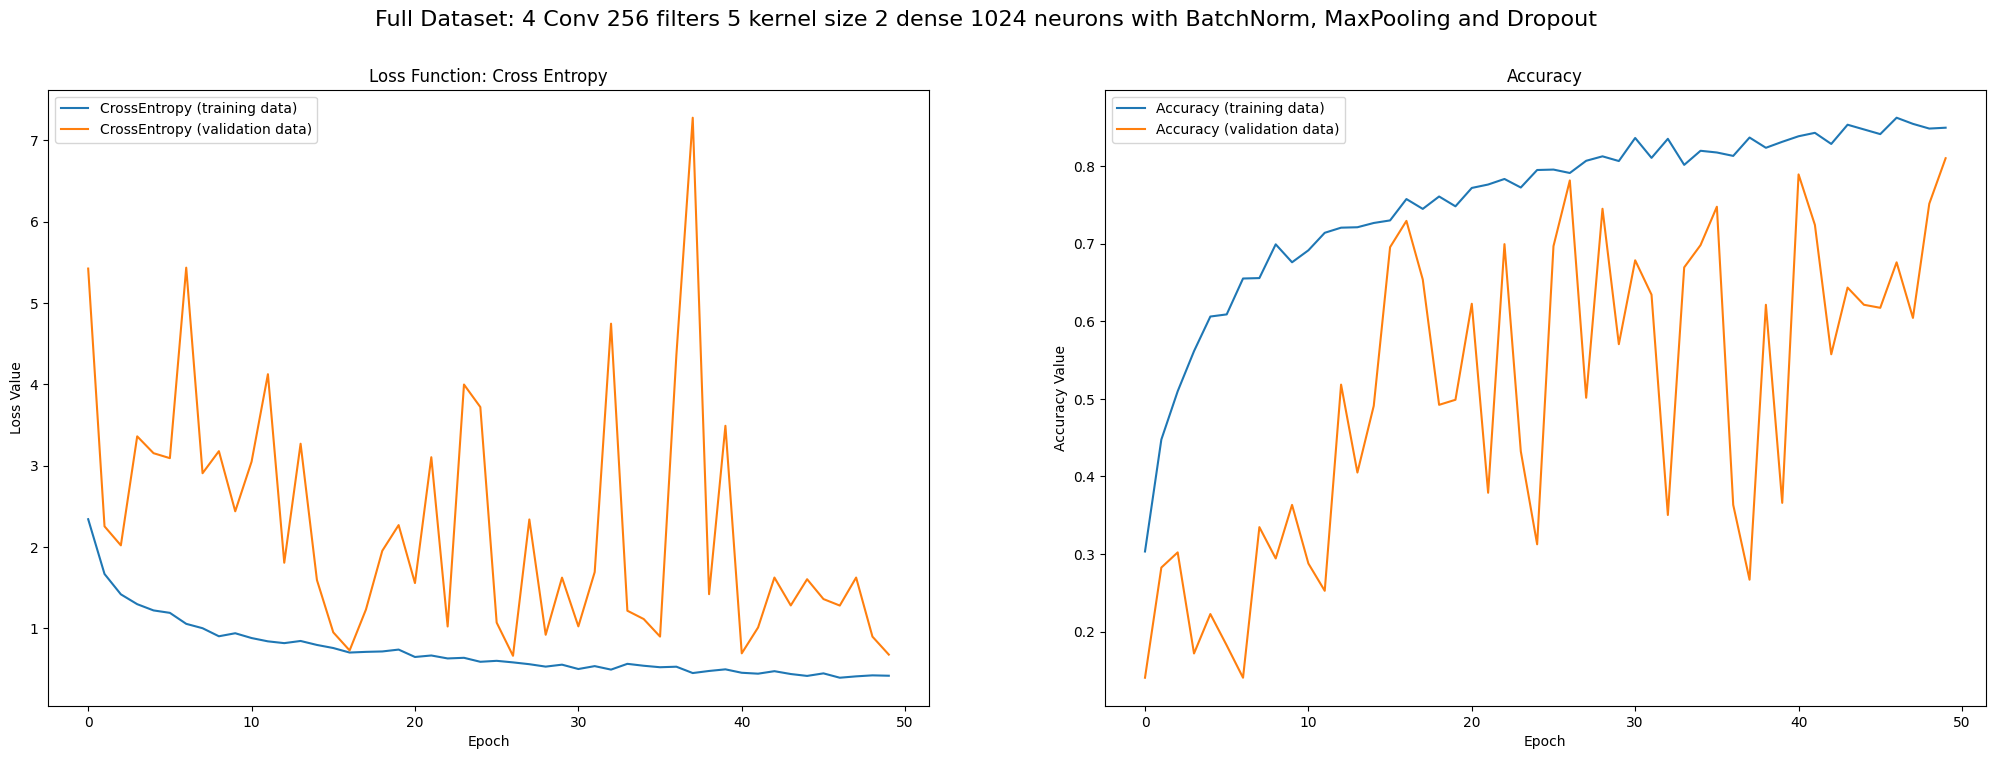

Train Accuracy: 0.7570  Train Loss: 0.7802
Test Accuracy: 0.8104  Test Loss: 0.6806


In [49]:
plot_loss_accuracy(history, "Full Dataset: {} Conv {} filters {} kernel size {} dense {} neurons with BatchNorm, MaxPooling and Dropout".format(N_CONV, CONV, KERNEL, N_DENSE, DENSE))
(loss, acc) = model.evaluate(train_big, verbose = 0)
print("Train Accuracy: {:.4f}  Train Loss: {:.4f}".format(acc,loss))
(loss, acc) = model.evaluate(test_big, verbose = 0)
print("Test Accuracy: {:.4f}  Test Loss: {:.4f}".format(acc,loss))